# 0. Install and Import dependencies

In [1]:
#!pip install stable-baselines3 gym-anytrading gym yfinance

In [2]:
# Gym stuff
import gymnasium as gym
import gym_anytrading

# Data API
import yfinance as yf

# Stable baselines - rl stuff
from stable_baselines3.common.vec_env import DummyVecEnv
from stable_baselines3 import A2C

# Processing libraries
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from datetime import datetime

# 1. Bring in Data 
This function fetches stock data from Yahoo Finance for the period 2024-01-01 to 2025-01-31.
It then cleans and processes the data, splitting it into:
1. Training set (df_train) → Contains all stock data from 2021-2023.
2. Testing set (df_test) → Contains stock data of 2024.

In [3]:
# Function to fetch, clean, and split stock data
def fetch_and_prepare_stock_data(ticker):
    
    # Download stock data for 2024 and January 2025
    df = yf.Ticker(ticker).history(start="2021-01-01", end="2024-12-31", interval="1d")

    # Ensure a copy to prevent warnings
    df = df.copy()

    # Format the Date index
    df["Date"] = pd.to_datetime(df.index)  
    df.index = df.index.date  # Convert to `datetime.date` objects

    # Drop unnecessary columns
    df = df.drop(columns=['Dividends', 'Stock Splits', 'Date'])

    # Round all numerical values to 2 decimal places
    df = df.round(2)

    # ✅ Convert date strings to `datetime.date`
    train_start = datetime.strptime("2021-01-01", "%Y-%m-%d").date()
    train_end = datetime.strptime("2023-12-31", "%Y-%m-%d").date()
    test_start = datetime.strptime("2024-01-01", "%Y-%m-%d").date()
    test_end = datetime.strptime("2024-12-31", "%Y-%m-%d").date()

    # ✅ Use `.loc[]` with date objects instead of strings
    df_train = df.loc[train_start:train_end]
    df_test = df.loc[test_start:test_end]

    return df_train, df_test

In [4]:
# Fetch and prepare Tesla stock data
df_TSLA_train, df_TSLA_test = fetch_and_prepare_stock_data("TSLA")

In [5]:
# Display results
print("Train Data (2021-2023):")
print(df_TSLA_train.head())
print("\nTest Data (2024):")
print(df_TSLA_test.head())

Train Data (2021-2023):
              Open    High     Low   Close     Volume
2021-01-04  239.82  248.16  239.06  243.26  145914600
2021-01-05  241.22  246.95  239.73  245.04   96735600
2021-01-06  252.83  258.00  249.70  251.99  134100000
2021-01-07  259.21  272.33  258.40  272.01  154496700
2021-01-08  285.33  294.83  279.46  293.34  225166500

Test Data (2024):
              Open    High     Low   Close     Volume
2024-01-02  250.08  251.25  244.41  248.42  104654200
2024-01-03  244.98  245.68  236.32  238.45  121082600
2024-01-04  239.25  242.70  237.73  237.93  102629300
2024-01-05  236.86  240.12  234.90  237.49   92379400
2024-01-08  236.14  241.25  235.30  240.45   85166600


In [6]:
df_TSLA_train.dtypes

Open      float64
High      float64
Low       float64
Close     float64
Volume      int64
dtype: object

# 2. Build and Test Env

In [7]:
env = gym.make('stocks-v0', df=df_TSLA_train, frame_bound=(5,250), window_size=5)

In [8]:
print(env.unwrapped.prices) #By default, gym-anytrading uses the Close Price as prices.

[243.26 245.04 251.99 272.01 293.34 270.4  283.15 284.8  281.67 275.39
 281.52 283.48 281.66 282.21 293.6  294.36 288.05 278.48 264.51 279.94
 290.93 284.9  283.33 284.08 287.81 283.15 268.27 270.55 272.04 265.41
 266.05 262.46 260.43 238.17 232.95 247.34 227.41 225.17 239.48 228.81
 217.73 207.15 199.32 187.67 224.53 222.69 233.2  231.24 235.98 225.63
 233.94 217.72 218.29 223.33 220.72 210.09 213.46 206.24 203.76 211.87
 222.64 220.58 230.35 230.54 223.66 227.93 225.67 233.99 254.11 244.08
 246.28 246.59 238.21 239.66 248.04 239.9  243.13 246.07 234.91 231.47
 225.67 236.48 228.3  224.53 223.65 221.18 224.12 209.68 205.73 196.63
 190.56 196.58 192.28 192.62 187.82 195.59 193.63 202.15 201.56 206.38
 210.28 208.41 207.97 201.71 190.95 199.68 201.71 201.2  199.59 203.37
 203.3  205.9  199.79 201.62 205.53 207.77 206.94 207.9  218.86 226.61
 223.96 229.57 226.92 226.57 225.97 226.3  219.86 214.88 217.6  218.98
 228.57 222.85 217.79 216.87 214.74 215.41 220.17 218.43 216.42 214.46
 219.2

In [9]:
env.action_space

Discrete(2)

Run 1:
info: {'total_reward': np.float32(-79.65999), 'total_profit': np.float32(0.33292133), 'position': <Positions.Long: 1>}


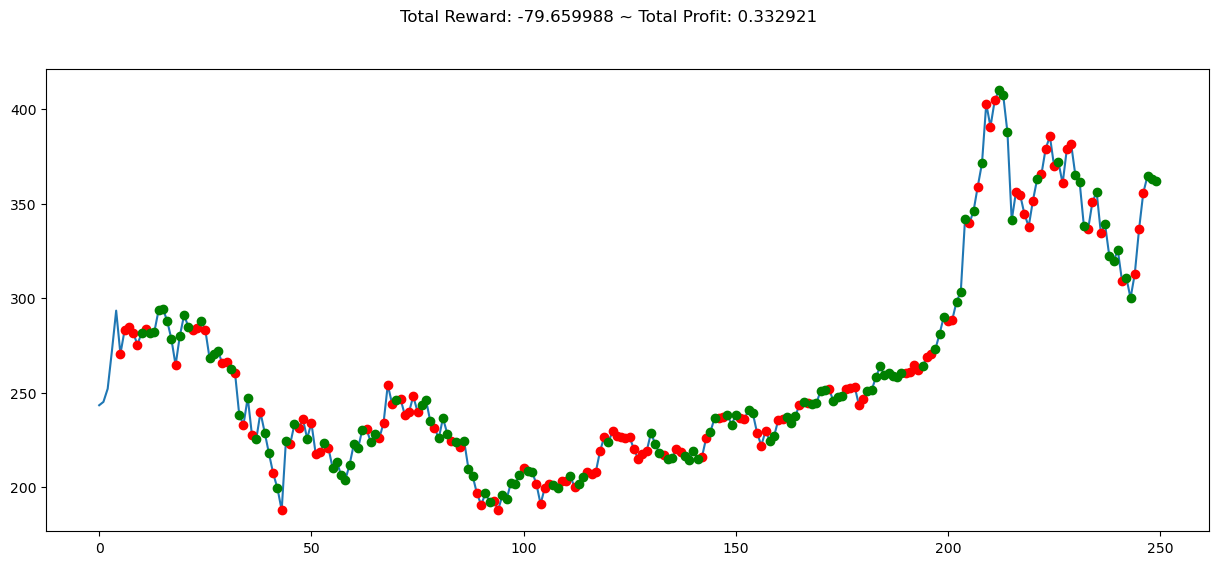

Run 2:
info: {'total_reward': np.float32(-128.2), 'total_profit': np.float32(0.24755803), 'position': <Positions.Short: 0>}


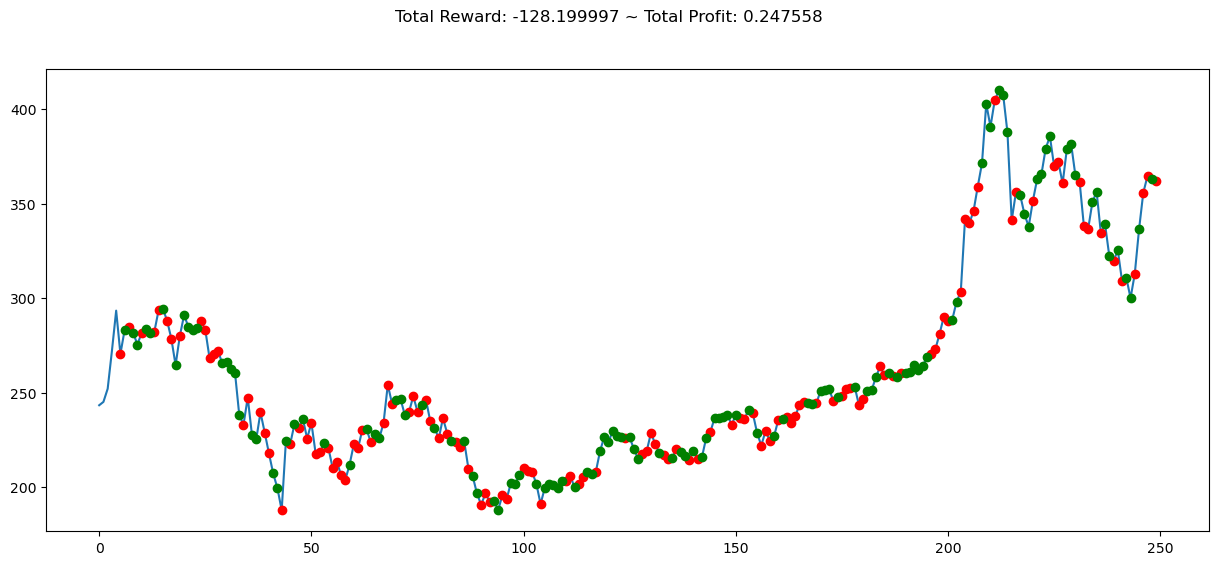

Run 3:
info: {'total_reward': np.float32(-10.410095), 'total_profit': np.float32(0.40676752), 'position': <Positions.Long: 1>}


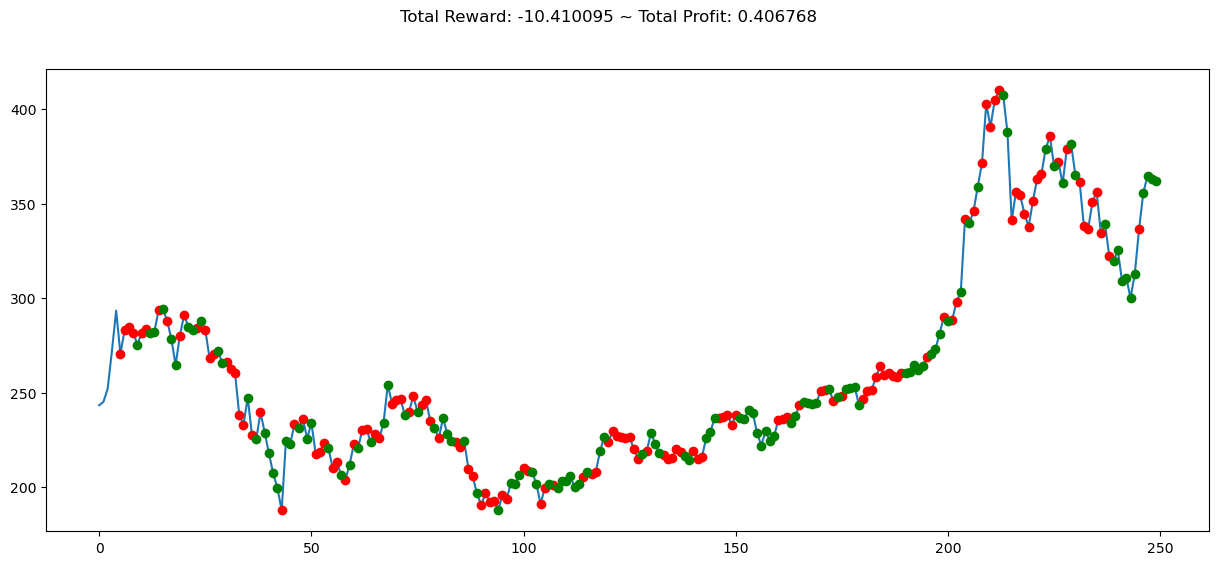

In [10]:
for i in range(3):  # Run multiple times
    print(f"Run {i+1}:")

    # Reset environment with a random seed
    state = env.reset(seed=np.random.randint(1000))  

    while True:
        action = env.action_space.sample()
        n_state, reward, terminated, truncated, info = env.step(action)

        done = terminated or truncated
        if done:
            print("info:", info)
            break

    # Plot results for this run
    plt.figure(figsize=(15,6))
    plt.cla()
    env.unwrapped.render_all()
    plt.show()

# 3. Build Environment and Train

In [15]:
# Create a lambda function that initializes the environment
def env_maker():
    return gym.make('stocks-v0', df=df_TSLA_train, frame_bound=(10, len(df_TSLA_train)), window_size=10)

# Wrap in DummyVecEnv
env = DummyVecEnv([env_maker])

In [16]:
model = A2C('MlpPolicy', env, verbose=1)
model.learn(total_timesteps=100000)

Using cpu device
------------------------------------
| time/                 |          |
|    fps                | 1645     |
|    iterations         | 100      |
|    time_elapsed       | 0        |
|    total_timesteps    | 500      |
| train/                |          |
|    entropy_loss       | -0.606   |
|    explained_variance | -0.0263  |
|    learning_rate      | 0.0007   |
|    n_updates          | 99       |
|    policy_loss        | 1.04     |
|    value_loss         | 4.39     |
------------------------------------
------------------------------------
| time/                 |          |
|    fps                | 1683     |
|    iterations         | 200      |
|    time_elapsed       | 0        |
|    total_timesteps    | 1000     |
| train/                |          |
|    entropy_loss       | -0.689   |
|    explained_variance | 0        |
|    learning_rate      | 0.0007   |
|    n_updates          | 199      |
|    policy_loss        | -0.238   |
|    value_loss      

# 4. Evaluation

In [24]:
# Create Testing Environment
env = gym.make('stocks-v0', df=df_TSLA_test, frame_bound=(10, len(df_TSLA_test)), window_size=10)

# Reset the environment and unpack obs, info
obs, _ = env.reset()

while True:
    obs = obs[np.newaxis, ...]
    action, _states = model.predict(obs)
    obs, rewards, terminated, truncated, info = env.step(action)

    done = terminated or truncated  # Ensure proper episode ending
    if done:
        print("info:", info)
        break

info: {'total_reward': 0.0, 'total_profit': np.float32(1.9405782), 'position': <Positions.Long: 1>}


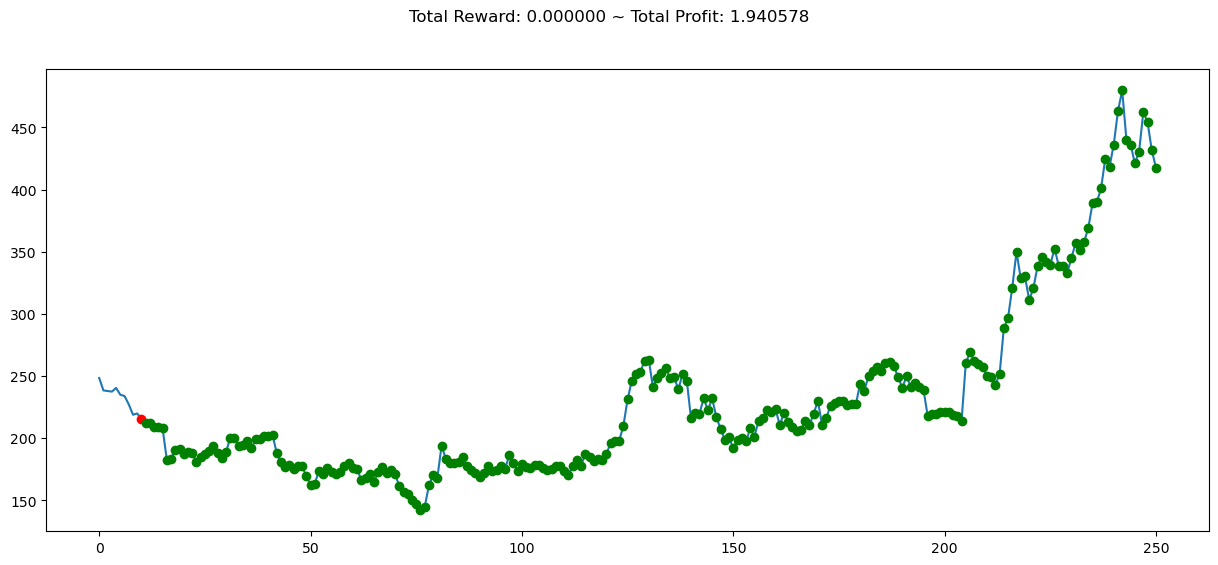

In [25]:
plt.figure(figsize=(15,6))
plt.cla()
env.unwrapped.render_all()
plt.show()